# **Introduction**

**Models Implemented:**

1)RNN

2)LSTM

3)BiLSTM


->Importing required Libraries

->Converting text files to csv files

->Reading data set from csv files




In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout,Bidirectional
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
!pip install keras.utils
import keras.utils
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Readind Data from CSV Files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
filepaths = glob.glob(os.path.join('gdrive/My Drive/Task1test/', "*.txt"))
 # iterate for each file in the list
for fp in filepaths:
   df = pd.read_csv(fp,header=None,sep='\t',delimiter=None)
   df.columns = ['sentence', 'role']
   df.to_csv(f'{fp.split(sep=".")[0]}.csv')

In [ ]:
path = os.getcwd()
filepaths = glob.glob(os.path.join('gdrive/My Drive/Task1/', "*.csv"))
li = []
for filename in filepaths:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True)

df=df.loc[:, ~df.columns.str.match('Unnamed')]
df

,sentence,role
0,The main question raised in this appeal by spe...,Ratio of the decision
1,"Act,1953 (Bombay Act",Ratio of the decision
2,No.XXXIX of 1954) declares that a particular J...,Ratio of the decision
3,No,Ratio of the decision
4,V of 1879) with a view to determining whether ...,Ratio of the decision
...,...,...
218773,"The judgment of the High Court,therefore,canno...",Ruling by Present Court
218774,It is set aside accordingly and the order of d...,Ruling by Present Court
218775,The appeal is allowed,Ruling by Present Court
218776,No costs,Ruling by Present Court


In [ ]:
path = os.getcwd()
filepaths = glob.glob(os.path.join('gdrive/My Drive/Task1test/', "*.csv"))
li = []
for filename in filepaths:
    df_test = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_test)
    df_test = pd.concat(li, axis=0, ignore_index=True)

df_test=df_test.loc[:, ~df_test.columns.str.match('Unnamed')]
df_test

,sentence,role
0,The question involved in this case is whether ...,Ratio of the decision
1,The appellant is the owner of Flat no. 2 (now ...,Facts
2,The said premises had been leased out in favou...,Facts
3,The respondent committed default in the paymen...,Facts
4,"The appellant, therefore, served a notice on t...",Statute
...,...,...
639,We see no reason for interfering with the find...,Ratio of the decision
640,"The result, therefore, is that the workmen are...",Ruling by Present Court
641,We accordingly modify the award of the industr...,Ruling by Present Court
642,There will no order as to costs.,Ruling by Present Court


In [ ]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218778 entries, 0 to 218777
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  218778 non-null  object
 1   role      218778 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


((218778, 2), None)

In [ ]:
df['role'].value_counts()

Ratio of the decision      82946
Facts                      51288
Precedent                  33520
Argument                   18696
Statute                    17386
Ruling by Lower Court       8320
Ruling by Present Court     6622
Name: role, dtype: int64

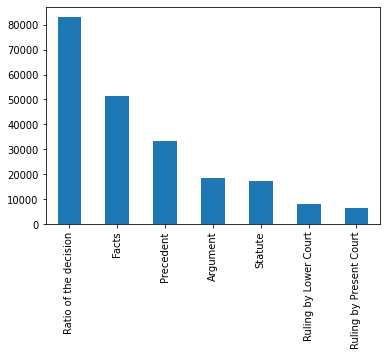

In [ ]:
df['role'].value_counts().plot(kind = 'bar')

In [ ]:
max_words = 50000
max_seq = 400
emb_dim = 128

# **Text Preprocessing**

In [ ]:
def preprocess_text_data(df):
  replace_by_space = re.compile('[/(){}\[\]\|@,;]')
  bad_sym = re.compile('[^0-9a-z #+_]')
  STOPWORDS = set(stopwords.words('english'))
  def clean_text(text):
    text = text.lower()
    text = replace_by_space.sub(' ',text)
    text = bad_sym.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
  df.dropna(subset = ['sentence'], inplace = True)
  df['sentence'] = df['sentence'].apply(clean_text)


  
  tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df['sentence'].values)
  word_index = tokenizer.word_index

  X = tokenizer.texts_to_sequences(df['sentence'].values)
  X = pad_sequences(X, maxlen= max_seq)
  y= pd.get_dummies(df['role']).values
  return X,y

In [ ]:
X,y = preprocess_text_data(df)

In [ ]:
X.shape,X

((218778, 400), array([[   0,    0,    0, ..., 1862, 2678, 1949],
        [   0,    0,    0, ..., 2379,  336,    2],
        [   0,    0,    0, ...,  136,  336,    2],
        ...,
        [   0,    0,    0, ...,    0,   17,  201],
        [   0,    0,    0, ...,    0,    0,  540],
        [   0,    0,    0, ...,    0,   17,  201]], dtype=int32))

In [ ]:
y.shape, y

((218778, 7), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=uint8))

# **Split Data**

In [ ]:
def split_data(X,y):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 41)
  return x_train, x_test, y_train, y_test

# **Testing Data Function**

In [ ]:
def test(x_test,y_test):
  y_pred=model.predict(x_test)
  y_pred=y_pred.argmax(axis=1)
  y_test=y_test.argmax(axis=1)
  return y_test,y_pred
def c_r(df,y_test,y_pred):
  cr = classification_report(y_test, y_pred,target_names= df['role'].unique())
  return cr
def c_m(y_test,y_pred):
  cm = confusion_matrix(y_test,y_pred,labels=[0,1,2,3,4,5,6])
  cm_df = pd.DataFrame(cm,index = ['Ratio of the decision', 'Facts','Precedent','Argument','Statute','Ruling by Lower Court','Ruling by Present Court'],
                     columns = ['Ratio of the decision', 'Facts','Precedent','Argument','Statute','Ruling by Lower Court','Ruling by Present Court'])
  return cm_df
def heat_map(model_name,cm_df,y_test,y_pred):
  plt.figure(figsize=(20,10))
  sns.heatmap(cm_df, annot=True, fmt="d", cmap='gist_heat')
  if model_name == '1':
      plt.title('RNN_Model:{0:.3f}'.format(accuracy_score(y_test,y_pred)))
  elif model_name == '2':
      plt.title('LSTM_model:{0:.3f}'.format(accuracy_score(y_test,y_pred)))
  else :
      plt.title('Bi_LSTM:{0:.3f}'.format(accuracy_score(y_test,y_pred)))
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# **RNN Model**

In [ ]:
x_train, x_test, y_train, y_test=split_data(X,y)
x_train, x_test, y_train, y_test

(array([[   0,    0,    0, ...,   35, 1465,  113],
        [   0,    0,    0, ...,    5, 1633,  216],
        [   0,    0,    0, ...,    0,    2, 1191],
        ...,
        [   0,    0,    0, ...,   76,  369,  207],
        [   0,    0,    0, ..., 3148, 1960,   64],
        [   0,    0,    0, ..., 3587, 5330, 1139]], dtype=int32),
 array([[   0,    0,    0, ...,  102,  139, 1660],
        [   0,    0,    0, ...,    0,  319, 4062],
        [   0,    0,    0, ...,    1,  270,  253],
        ...,
        [   0,    0,    0, ...,  276, 1010,  112],
        [   0,    0,    0, ...,  126, 1873,  549],
        [   0,    0,    0, ..., 3004,  940,  142]], dtype=int32),
 array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
       

In [ ]:
rnn_model = keras.models.Sequential([
    keras.layers.Embedding(max_words, emb_dim, input_length=X.shape[1]),
    keras.layers.SimpleRNN(128),
    keras.layers.Dense(7,activation='softmax')
])
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 128)          6400000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 6,433,799
Trainable params: 6,433,799
Non-trainable params: 0
_________________________________________________________________


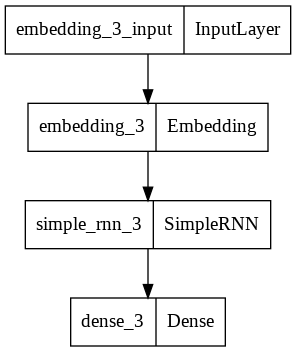

In [ ]:
plot_model(rnn_model,show_layer_names=True,show_shapes=False)

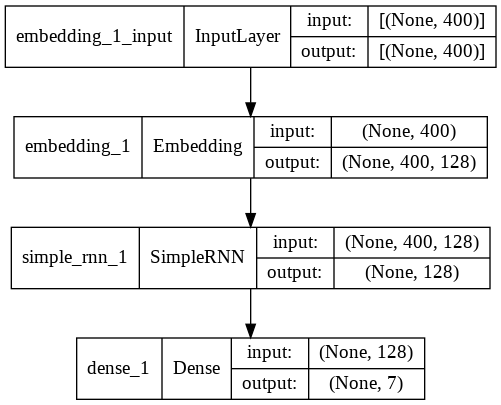

In [ ]:
plot_model(rnn_model,show_layer_names=True,show_shapes=True)

In [ ]:
history = rnn_model.fit(x_train, y_train, epochs=1, validation_data=(x_test,y_test))

5470/5470 [==============================] - 3435s 627ms/step - loss: 0.4887 - accuracy: 0.8312 - val_loss: 0.0801 - val_accuracy: 0.9739


In [ ]:
y_test,y_pred=test(x_test,y_test)

In [ ]:
cr=c_r(df,y_test,y_pred)

In [ ]:
cm_df=c_m(y_test,y_pred)

In [ ]:
model_name = '1'

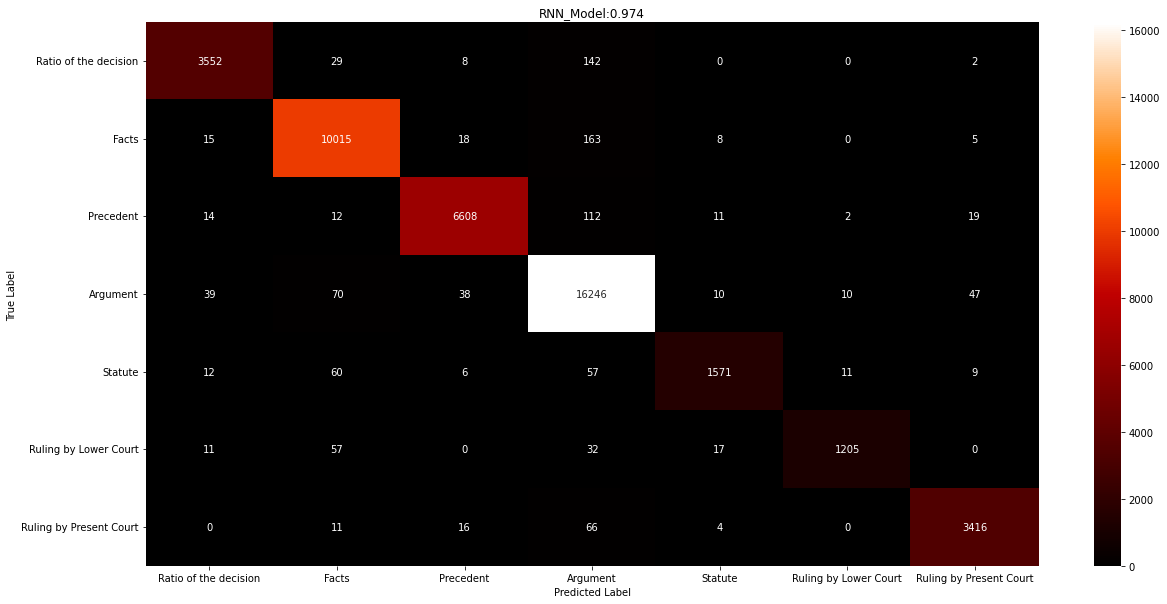

In [ ]:
heat_map(model_name,cm_df,y_test,y_pred)

In [ ]:
df1= df_test
x1,y1=preprocess_text_data(df1)

In [ ]:
y1_test,y1_pred=test(x1,y1)

In [ ]:
cr1=c_r(df1,y1_test,y1_pred)

In [ ]:
print(cr1)

                         precision    recall  f1-score   support

  Ratio of the decision       0.17      0.50      0.25         2
                  Facts       0.00      0.00      0.00        16
                Statute       0.00      0.00      0.00         3
  Ruling by Lower Court       0.42      0.62      0.50        16
Ruling by Present Court       0.00      0.00      0.00         3
               Argument       0.00      0.00      0.00         5
              Precedent       0.00      0.00      0.00         1

               accuracy                           0.24        46
              macro avg       0.08      0.16      0.11        46
           weighted avg       0.15      0.24      0.18        46



In [ ]:
cm_df1=c_m(y1_test,y1_pred)

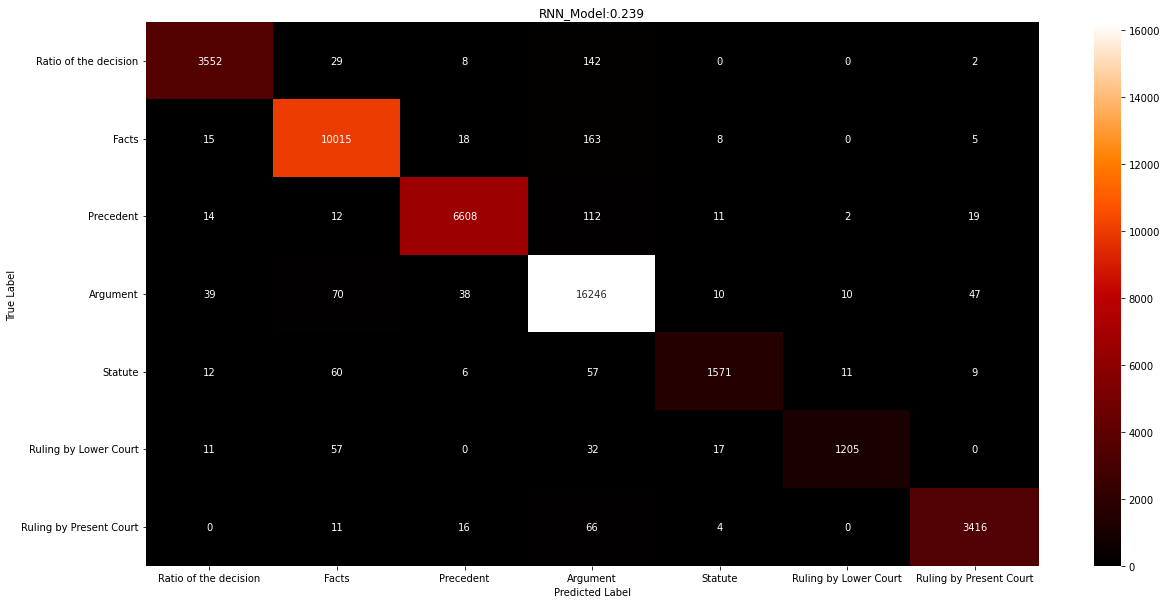

In [ ]:
heat_map(model_name,cm_df,y1_test,y1_pred)

# **LSTM**

In [ ]:
x_train, x_test, y_train, y_test=split_data(X,y)
x_train, x_test, y_train, y_test

(array([[   0,    0,    0, ...,   35, 1465,  113],
        [   0,    0,    0, ...,    5, 1633,  216],
        [   0,    0,    0, ...,    0,    2, 1191],
        ...,
        [   0,    0,    0, ...,   76,  369,  207],
        [   0,    0,    0, ..., 3148, 1960,   64],
        [   0,    0,    0, ..., 3587, 5330, 1139]], dtype=int32),
 array([[   0,    0,    0, ...,  102,  139, 1660],
        [   0,    0,    0, ...,    0,  319, 4062],
        [   0,    0,    0, ...,    1,  270,  253],
        ...,
        [   0,    0,    0, ...,  276, 1010,  112],
        [   0,    0,    0, ...,  126, 1873,  549],
        [   0,    0,    0, ..., 3004,  940,  142]], dtype=int32),
 array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
       

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(max_words, emb_dim, input_length=X.shape[1]))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units = 128, return_sequences = True))
model_2.add(Dropout(0.2))


model_2.add(LSTM(units = 128, return_sequences = True))
model_2.add(LSTM(units = 128, return_sequences = True))
model_2.add(LSTM(units = 64))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = 7))

model_2.add(Dense(7, activation='softmax'))

model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


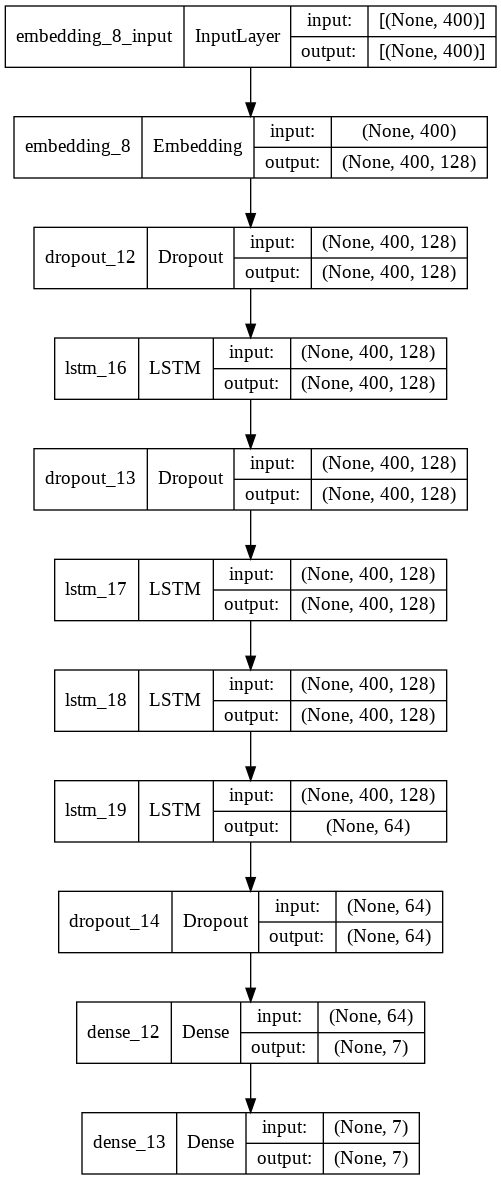

In [ ]:
plot_model(model_2,show_shapes=True)

In [ ]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 400, 128)          6400000   
                                                                 
 dropout_12 (Dropout)        (None, 400, 128)          0         
                                                                 
 lstm_16 (LSTM)              (None, 400, 128)          131584    
                                                                 
 dropout_13 (Dropout)        (None, 400, 128)          0         
                                                                 
 lstm_17 (LSTM)              (None, 400, 128)          131584    
                                                                 
 lstm_18 (LSTM)              (None, 400, 128)          131584    
                                                                 
 lstm_19 (LSTM)              (None, 64)               

In [ ]:
history = model_2.fit(x_train, y_train, validation_split=0.2, epochs=11, batch_size = 512)

Epoch 1/11
 35/274 [==>...........................] - ETA: 2:39 - loss: 1.6728 - accuracy: 0.3728

KeyboardInterrupt: ignored

In [ ]:
model_name = '2'

In [ ]:
y_test,y_pred=test(x_test,y_test)

In [ ]:
cr=c_r(df,y_test,y_pred)

In [ ]:
cm_df=c_m(y_test,y_pred)

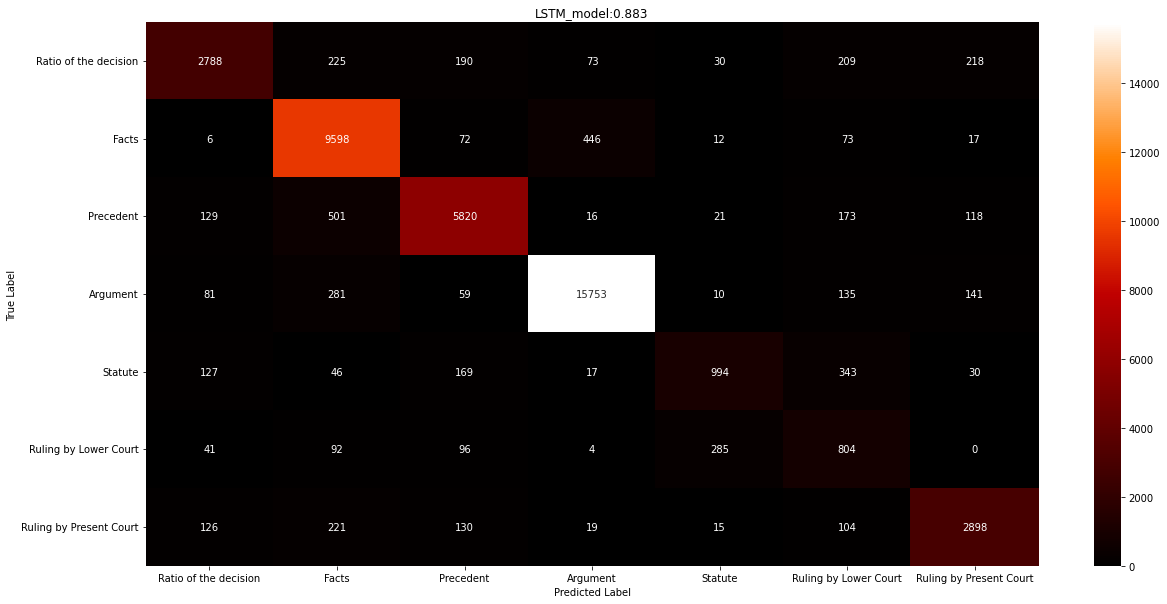

In [ ]:
heat_map(model_name,cm_df,y_test,y_pred)

In [ ]:
df2= df_test
df2

,sentence,role
0,The question involved in this case is whether ...,Ratio of the decision
1,The appellant is the owner of Flat no. 2 (now ...,Facts
2,The said premises had been leased out in favou...,Facts
3,The respondent committed default in the paymen...,Facts
4,"The appellant, therefore, served a notice on t...",Statute
...,...,...
639,We see no reason for interfering with the find...,Ratio of the decision
640,"The result, therefore, is that the workmen are...",Ruling by Present Court
641,We accordingly modify the award of the industr...,Ruling by Present Court
642,There will no order as to costs.,Ruling by Present Court


In [ ]:
df2 = shuffle(df2)


In [ ]:
x2,y2=preprocess_text_data(df2)

In [ ]:
y2_test,y2_pred=test(x2,y2)

In [ ]:
cr2=c_r(df2,y2_test,y2_pred)
print(cr2)

                         precision    recall  f1-score   support

  Ratio of the decision       0.09      0.12      0.11        56
                  Facts       0.23      0.28      0.25       149
  Ruling by Lower Court       0.06      0.11      0.07        55
Ruling by Present Court       0.44      0.30      0.35       295
              Precedent       0.04      0.04      0.04        25
               Argument       0.06      0.05      0.05        39
                Statute       0.00      0.00      0.00        25

               accuracy                           0.23       644
              macro avg       0.13      0.13      0.13       644
           weighted avg       0.27      0.23      0.24       644



In [ ]:
cm_df2=c_m(y2_test,y2_pred)

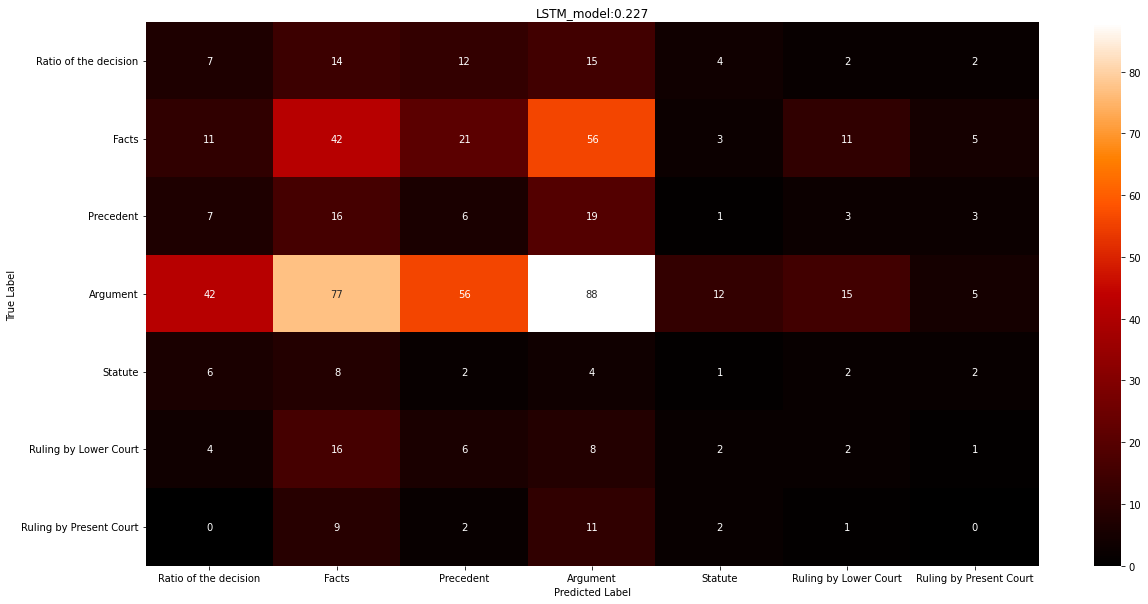

In [ ]:
heat_map(model_name,cm_df2,y2_test,y2_pred)

# **Bi-LSTM**

In [ ]:
x_train, x_test, y_train, y_test=split_data(X,y)
x_train, x_test, y_train, y_test

In [ ]:
model_3 = Sequential()
model_3.add(Embedding(max_words, emb_dim, input_length=X.shape[1]))
model_3.add(SpatialDropout1D(0.2))
model_3.add(Bidirectional(LSTM(100, recurrent_dropout=0.2)))
model_3.add(Dense(7, activation='softmax'))

model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
plot_model(model_3,show_shapes=True)

In [ ]:
model_3.summary()

In [ ]:
history = model_3.fit(x_train, y_train, validation_split=0.2, epochs=11, batch_size = 512)

In [ ]:
model_name = '3'

In [ ]:
y_test,y_pred=test(x_test,y_test)

In [ ]:
cr=c_r(df,y_test,y_pred)

In [ ]:
cm_df=c_m(y_test,y_pred)

In [ ]:
heat_map(model_name,cm_df,y_test,y_pred)

In [ ]:
df3= df_test

In [ ]:
x3,y3=preprocess_text_data(df3)

In [ ]:
y3_test,y3_pred=test(x3,y3)

In [ ]:
cr3=c_r(df,y3_test,y3_pred)

In [ ]:
cm_df3=c_m(y3_test,y3_pred)

In [ ]:
heat_map(model_name,cm_df3,y3_test,y3_pred)